# TP1 - Redes Neuronales II (parte 1 de 3)
## Francisco Mendizabal
## Legajo 61454

## Consignas:

### 1- Usar las vectorizaciones disponibles en sklearn de CountVectorizer y TfidfVectorizer para construir la matriz de documento-término. Esto proveerá de embeddings para cada documento. Con esta vectorización explorar similaridad entre documentos (tomar algún documento y evaluar los documentos correspondientes con mayor similaridad), dado que el dataset provee también clasificación anotada en tópicos se aprovechar esta clasificación como elemento extra para comprobar la similaridad de documentos. Explorar vectorizar con diferentes cantidades de n-gramas. Toda exploración adicional a las mencionadas es bienvenida.

### 2- Repetir la exploración de similaridad de documentos pero utilizando la vectorización resultante de aplicar truncated SVD (disponible en sklearn) a la matriz de documento-término.

## Setup

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np

<img src="tf.png" >
<img src="idf.png" >
<img src="tfidf.png" >

In [2]:
TNG_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))

In [8]:
cv1 = CountVectorizer(ngram_range=(1,2), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")
cv2 = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")

In [9]:
# Configuro si quiero TruncatedSVD o no
SVD = False

# Configuro si quiero CountVectorizer o TFIDF
cv = cv1

In [10]:
TNG_cv = cv.fit_transform(TNG_train.data)

if SVD:
    red = TruncatedSVD(n_components=300)
    TNG_cv_red = red.fit_transform(TNG_cv)
    print(TNG_cv_red.shape)
else:
    print(TNG_cv.shape)

(11314, 10605)


In [11]:
#Tamaño del vocabulario
print(f'El tamaño del vocabulario es: {len(cv.get_feature_names_out())}')

El tamaño del vocabulario es: 10605


## Cálculo del Document Frecuency de Palabras

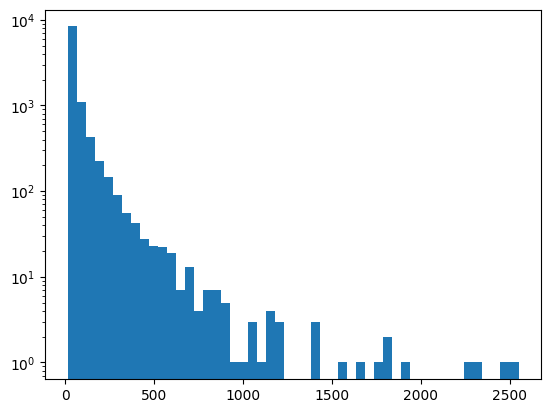

In [30]:
if not SVD:
    doc_freq = np.array(TNG_cv.astype(bool).sum(axis=0)).flatten()
    plt.hist(doc_freq, bins=50, log=True)
    plt.show()

## Similitud entre Palabras

In [14]:
if SVD:
    np.linalg.norm(TNG_cv_red, axis=0)
else:
    np.linalg.norm(TNG_cv.todense(), axis=0)

In [16]:
# No necesito normalizar pero tampoco está mal hacerlo
if SVD:
    TNG_norm = (TNG_cv_red.T/(np.linalg.norm(TNG_cv_red, axis=-1)+1e-8)).T
else:
    TNG_norm = (TNG_cv.toarray().T/(np.linalg.norm(TNG_cv.toarray(), axis=-1)+1e-8)).T

In [17]:
TNG_train.data[2727]

'\n\nThe Bible does tell us that governments are ordained by God (Romans 13).\n And furthermore, God foreknows everything that would happen.  It is\njust to difficult for humans to graps with our limited minds, the\ninevitablity of the sucess of God\'s plan, and this is especially hard to\ngrasp when we see governemnts doing evil.  However, though they are\ndoing evil (and we should not cooperate with them when they do such), it\nmust be understood that what happens is what God wanted so as to lead to\nthe final sucess of His plan to save as many souls from hell as is\npossible.  In short, the slaughter in Bosnia, though deplorable in the\neyes of God (maybe, then again, they might be getting their just deserts\nnow rather than later; there are plenty of examples of God killing\npeople for their sins - Onan in the Old Testmament for example, and\nAnnias and Spahira in the New) is what he willed to happen so that His\nplan might be accomplished.\n    But don\'t forget, it is not unbibli

In [25]:
cosines = np.dot(TNG_norm[2727], TNG_norm.T)
print(max(cosines))

0.999999999123784


In [29]:
# Se observaron las diferentes categorias existentes
TNG_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [24]:
neigh_idx = np.array(cosines).flatten().argsort()[::-1]

In [28]:
for idx in neigh_idx[0:9]:
    print(f'Documento N° {idx} \n  Tópico: \t{TNG_train.target_names[TNG_train.target[idx]]} \n  Similitud: \t{cosines[idx]}')

Documento N° 2727 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.999999999123784
Documento N° 5559 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.5594336886859461
Documento N° 6962 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.5559779102402538
Documento N° 5826 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.5465135883520625
Documento N° 10571 
  Tópico: 	talk.religion.misc 
  Similitud: 	0.5359881172208937
Documento N° 3793 
  Tópico: 	talk.religion.misc 
  Similitud: 	0.5128056766271955
Documento N° 10649 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.4948138458736561
Documento N° 6951 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.4900110312989631
Documento N° 7999 
  Tópico: 	soc.religion.christian 
  Similitud: 	0.4793134860048478


### 1) Primero se probaron CountVectorizer y TFIDF con diferentes parámetros. Utilizando el bloque anterior, se calculó la similitud coseno en los casos que se indican en cada celda de las tablas, partiendo como referencia del archivo 2727.
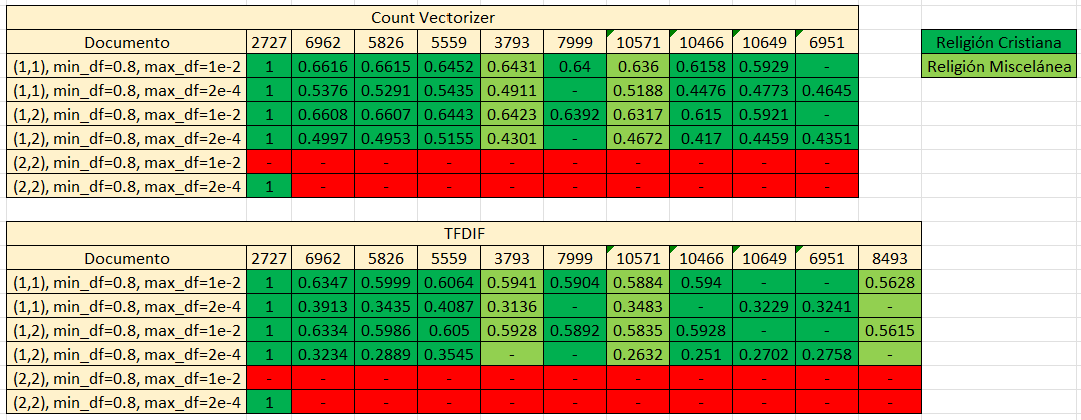
### Se observó que cambios en el max_df no eran significativos, ya que ninguna palabra aparecía con tanta regularidad. Por otra parte, las modificaciones del min:df cambiaban radicalmente el tamaño de la matríz término documento. Cuando se utilizaba el valor de 1e-2, el resultado era que se recortaban demasiadas palabras, lo cual dificultaba la diferenciación de los textos (lo cual produce similitudes más elevadas). El valor de 2e-4 conseguía esto de una mejor manera, pero el costo computacional era mucho mayor.
### La utilización de bigramas no presentó mejorar sustanciales en comparación a los unigramas. Por otro lado, los unigramas resultan esenciales por sí mismos, ya que en los casos donde no se utilizaron, la mayoría de los textos obtenidos ni siquiera coincidían con la categoría del texto original.

### 2) Para analizar el SVD, se partió de el caso con CV (1,2) con max_df=2e-4, y el único parámetro que se modificó fue n_components.
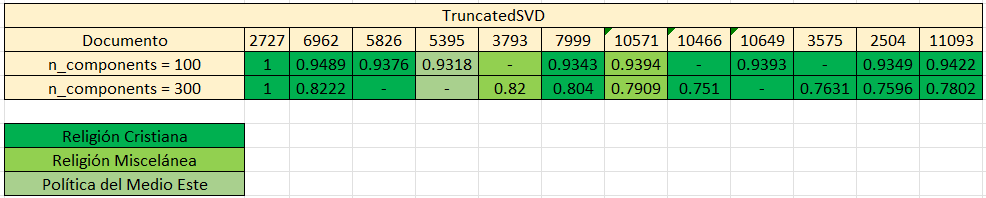
### En el caso con menos componentes, vemos que no se distinguen demasiado los archivos, ya que las similitudes son demasiado altas, e incluso aparecen documentos de temas con menor relación al tópico del documento original.